In [22]:
import re

# 假设日志信息存储在名为 "log_file.txt" 的文件中
file_path = "./slurm-9215267.out"

# 读取文件内容
with open(file_path, 'r') as file:
    log_data = file.read()

# 使用正则表达式提取 makespan 和 real EC
makespan_values = [float(value) for value in re.findall(r'makespan: ([\d.]+)', log_data)]
real_ec_values = [float(value)/10 for value in re.findall(r'real EC: ([\d.]+)', log_data)]

# 以 (makespan, real EC) 的浮点数形式存储
makespan_real_ec_pairs = list(zip(makespan_values, real_ec_values))

makespan_real_ec_pairs



[(388.65, 469.941909),
 (391.3, 460.412875),
 (399.2, 456.335796),
 (380.6, 457.167478),
 (401.2, 482.441913),
 (405.15, 461.33417099999997),
 (387.65, 462.64702100000005),
 (399.9, 469.158259),
 (372.5, 456.12172899999996),
 (390.95, 470.816778),
 (402.1, 457.380203),
 (374.85, 457.676325),
 (374.6, 445.673208),
 (365.1, 444.790936),
 (365.35, 430.95593099999996),
 (356.45, 441.25510299999996),
 (348.9, 433.61216700000006),
 (354.75, 432.106533),
 (356.0, 423.83787),
 (371.8, 420.61430899999993),
 (357.65, 415.496285),
 (342.75, 413.100166),
 (349.5, 420.584001),
 (346.25, 412.837575),
 (341.5, 425.937144),
 (341.0, 416.956765),
 (350.1, 419.161563),
 (339.5, 408.154024),
 (338.8, 411.49836400000004),
 (335.55, 415.275047),
 (343.35, 396.809388),
 (342.35, 404.15933),
 (334.55, 408.42154999999997),
 (323.0, 395.190768),
 (325.35, 400.885986),
 (343.45, 404.424614),
 (328.55, 399.47966),
 (341.75, 410.59440299999994),
 (332.9, 397.274222),
 (343.6, 403.650711),
 (341.8, 408.47751600000

In [23]:
import numpy as np

# 提取到的 makespan 和 real EC 数据
# makespan_real_ec_pairs = [
#     (331.05, 3861.91355),
#     (327.85, 3844.77616),
#     (325.05, 3784.39160),
#     (337.05, 3916.30135),
#     (328.50, 3897.20008)
# ]

# 将数据转换为 numpy 数组
data = np.array(makespan_real_ec_pairs)

# 查找 Pareto 支配集
def is_dominated(p1, p2):
    return all(p1 <= p2) and any(p1 < p2)

pareto_front = []
for i, point in enumerate(data):
    dominated = False
    for j, other_point in enumerate(data):
        if i != j and is_dominated(other_point, point):
            dominated = True
            break
    if not dominated:
        pareto_front.append(tuple(point))

pareto_front


[(303.1, 383.161583),
 (316.9, 368.57503299999996),
 (313.6, 371.072431),
 (304.1, 377.011606),
 (308.2, 372.446828),
 (303.55, 377.619482),
 (303.3, 382.144232),
 (307.25, 376.54540000000003)]

In [24]:
import numpy as np
from scipy.spatial import ConvexHull

# 假设我们有两个解集的解
pareto_set_1 = np.array([ [276, 519.9], [337, 484.1], [337,484.1]
                         ,[303, 444.9], [317.1, 532.5], [317.1, 534.5], 
                         ])
pareto_set_2 = np.array(pareto_front)

# 定义参考点
reference_point = np.array([2000, 300])

def hypervolume(pareto_set, reference_point):
    # 将参考点添加到解集中以形成闭合区域
    points = np.vstack([pareto_set, reference_point])
    hull = ConvexHull(points)
    return hull.volume

# 计算两个算法的超体积
hv_1 = hypervolume(pareto_set_1, reference_point)
hv_2 = hypervolume(pareto_set_2, reference_point)

print(f"Algorithm 1 Hypervolume: {hv_1}")
print(f"Algorithm 2 Hypervolume: {hv_2}")


Algorithm 1 Hypervolume: 78785.49500000014
Algorithm 2 Hypervolume: 11850.601069474962


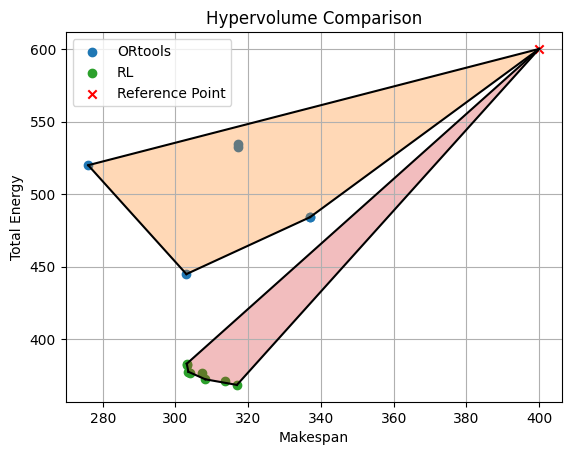

In [26]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import ConvexHull

# 定义参考点
reference_point = np.array([400, 600])

# 函数计算超体积
def plot_hypervolume(pareto_set, reference_point, ax, label):
    # 将参考点添加到解集中以形成闭合区域
    points = np.vstack([pareto_set, reference_point])
    hull = ConvexHull(points)

    # 绘制解集
    ax.scatter(pareto_set[:, 0], pareto_set[:, 1], label=label)
    
    # 绘制凸包
    for simplex in hull.simplices:
        ax.plot(points[simplex, 0], points[simplex, 1], 'k-')

    # 填充超体积区域
    ax.fill(points[hull.vertices, 0], points[hull.vertices, 1], alpha=0.3)
    if label != "RL": return
    ax.scatter(reference_point[0], reference_point[1], c='red', marker='x', label='Reference Point')

# 创建子图
fig, ax = plt.subplots()

# 绘制两个解集的超体积
plot_hypervolume(pareto_set_1, reference_point, ax, 'ORtools')
plot_hypervolume(pareto_set_2, reference_point, ax, 'RL')

# 标注
ax.set_xlabel('Makespan')
ax.set_ylabel('Total Energy')
ax.set_title('Hypervolume Comparison')
ax.legend()

# 显示图形
plt.grid(True)
plt.show()
